In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import xgboost as xgb
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay, classification_report

### Funções XGBoost

In [2]:


# XGBoost Normal
def XGBoost(df):
    # Dividir em treino e teste
    X = df.drop('diagnostico', axis=1)
    y = df['diagnostico']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    # Penaliza erros na classe minoritária
    if sum(y == 1) == 0:
        scale_pos_weight = 1  # Ou algum valor padrão
    else:
        scale_pos_weight = sum(y == 0) / sum(y == 1)
    
    params_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 4, 5],
        'min_child_weight': [2, 3, 4],
        'subsample': [0.6, 0.8, 1],
        'colsample_bytree': [0.5, 0.7]
    }

    classifier = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_classifier = GridSearchCV(classifier, params_grid, scoring='accuracy', cv=cv)
    grid_classifier.fit(X_val, y_val)
    
    best_parameters = grid_classifier.best_params_

    model = xgb.XGBClassifier(**best_parameters)

    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, pred)
    cm = confusion_matrix(y_test, pred)
    ppv = precision_score(y_test, pred)
    sensit = recall_score(y_test, pred)
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, pred)
    print(f"F1-Score: {f1:.4f}")
    print(f"Acurácia: {test_accuracy:.4f}")
    print(f"PPV (Precision): {ppv:.4f}")
    print(f"Sensibilidade (Recall): {sensit:.4f}")
    print(f"Especificidade: {specificity:.4f}")
    print(f"AUC: {auc_score:.4f}")
    
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, pred))
    
    print("\nMatriz de Confusão:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sem Sepse', 'Com Sepse'], yticklabels=['Sem Sepse', 'Com Sepse'])
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão')
    plt.show()


In [3]:
df_final = pd.read_csv('df_final.csv')
df_final[df_final['diagnostico'] == 1]['diagnostico'].value_counts()

diagnostico
1    774
Name: count, dtype: int64

In [4]:
# XGBoost com OverSampling
def XGBoost_Over(df):
    # Dividir em treino e teste
    X = df.drop('diagnostico', axis=1)
    y = df['diagnostico']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    X_train = pd.concat([X_train, y_train], axis=1)
    
    not_diagnostico = X_train[X_train.diagnostico==0]
    diagnostico = X_train[X_train.diagnostico==1]
    
    diagnostico_upsampled = resample(diagnostico, replace=True, n_samples=len(not_diagnostico), random_state=42)
    
    upsampled = pd.concat([not_diagnostico, diagnostico_upsampled])
    
    y_train = upsampled.diagnostico
    X_train = upsampled.drop('diagnostico', axis=1)

    scale_pos_weight = sum(y == 0) / sum(y == 1)

    params_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 4, 5],
        'min_child_weight': [2, 3, 4],
        'subsample': [0.6, 0.8, 1],
        'colsample_bytree': [0.5, 0.7]
    }

    classifier = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_classifier = GridSearchCV(classifier, params_grid, scoring='accuracy', cv=cv)
    grid_classifier.fit(X_val, y_val)
    
    best_parameters = grid_classifier.best_params_

    model = xgb.XGBClassifier(**best_parameters)

    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, pred)
    cm = confusion_matrix(y_test, pred)
    ppv = precision_score(y_test, pred)
    sensit = recall_score(y_test, pred)
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, pred)
    print(f"F1-Score: {f1:.4f}")
    print(f"Acurácia: {test_accuracy:.4f}")
    print(f"PPV (Precision): {ppv:.4f}")
    print(f"Sensibilidade (Recall): {sensit:.4f}")
    print(f"Especificidade: {specificity:.4f}")
    print(f"AUC: {auc_score:.4f}")

    print(classification_report(y_test, pred))
    print(confusion_matrix(y_test, pred))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Sem Sepse', 'Com Sepse'], yticklabels=['Sem Sepse', 'Com Sepse'])
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão')
    plt.show()

### Sem Tratar Missing

In [5]:
df_final = pd.read_csv('df_final.csv')

In [6]:
XGBoost(df_final)

Acurácia: 0.9901
PPV (Precision): 0.0204
Sensibilidade (Recall): 0.0072
Especificidade: 0.9974
AUC: 0.7135
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18720
           1       0.02      0.01      0.01       139

    accuracy                           0.99     18859
   macro avg       0.51      0.50      0.50     18859
weighted avg       0.99      0.99      0.99     18859

[[18672    48]
 [  138     1]]


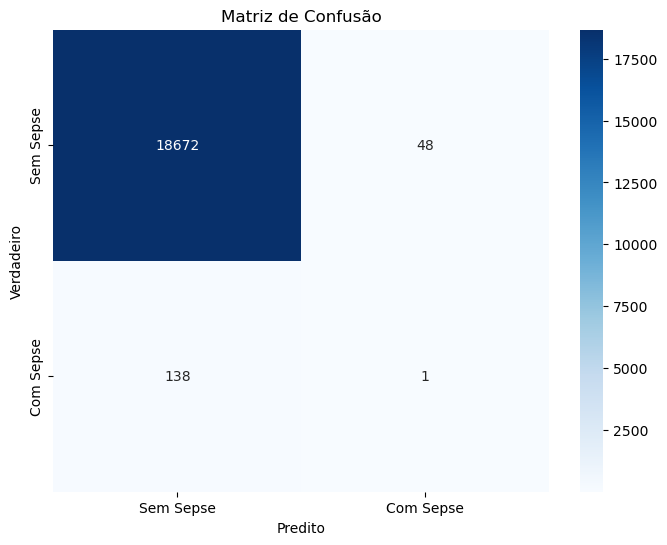

In [ ]:
XGBoost_Over(df_final)

### Valores Normais

In [ ]:
df_normal = pd.read_csv('df_normal.csv')

Acurácia: 0.9925
PPV (Precision): 0.0000
Sensibilidade (Recall): 0.0000
Especificidade: 0.9998
AUC: 0.7803

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18720
           1       0.00      0.00      0.00       139

    accuracy                           0.99     18859
   macro avg       0.50      0.50      0.50     18859
weighted avg       0.99      0.99      0.99     18859


Matriz de Confusão:
[[18717     3]
 [  139     0]]


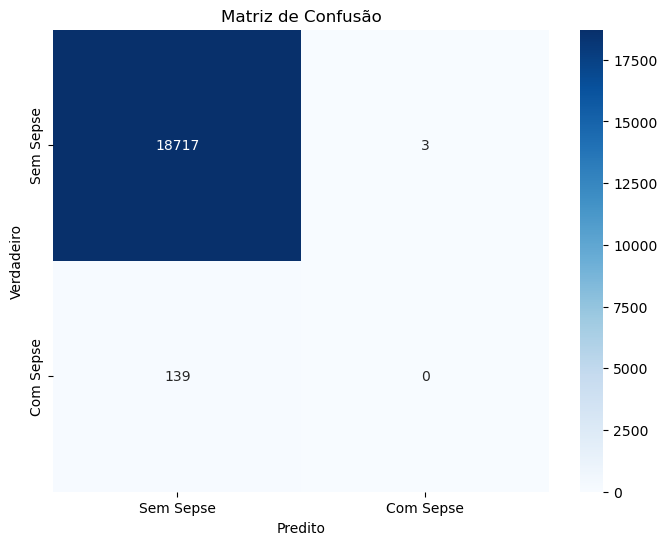

In [ ]:
XGBoost(df_normal)

Acurácia: 0.9898
PPV (Precision): 0.0656
Sensibilidade (Recall): 0.0288
Especificidade: 0.9970
AUC: 0.7287
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18720
           1       0.07      0.03      0.04       139

    accuracy                           0.99     18859
   macro avg       0.53      0.51      0.52     18859
weighted avg       0.99      0.99      0.99     18859

[[18663    57]
 [  135     4]]


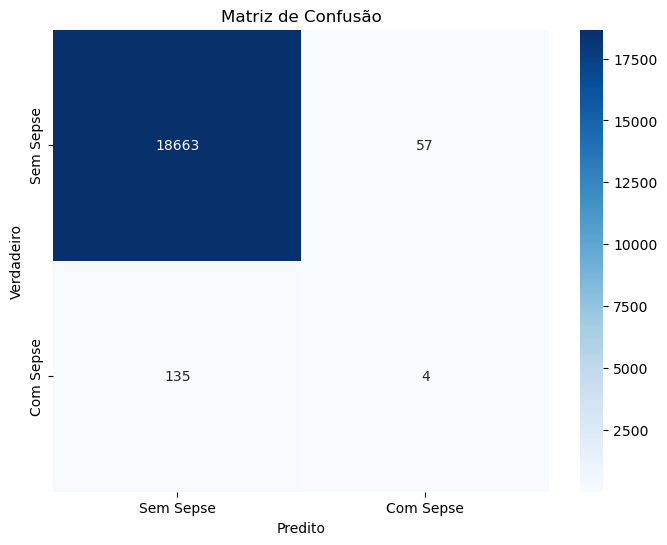

In [ ]:
XGBoost_Over(df_normal)

### KNN

In [ ]:
df_knn = pd.read_csv('df_knn.csv')

Acurácia: 0.9925
PPV (Precision): 0.2500
Sensibilidade (Recall): 0.0072
Especificidade: 0.9998
AUC: 0.7536

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18720
           1       0.25      0.01      0.01       139

    accuracy                           0.99     18859
   macro avg       0.62      0.50      0.51     18859
weighted avg       0.99      0.99      0.99     18859


Matriz de Confusão:
[[18717     3]
 [  138     1]]


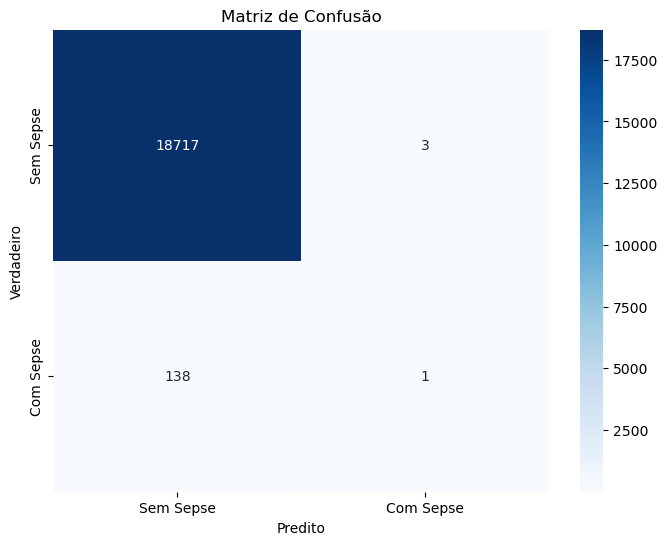

In [ ]:
XGBoost(df_knn)

Acurácia: 0.9908
PPV (Precision): 0.0750
Sensibilidade (Recall): 0.0216
Especificidade: 0.9980
AUC: 0.6964
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18720
           1       0.07      0.02      0.03       139

    accuracy                           0.99     18859
   macro avg       0.53      0.51      0.51     18859
weighted avg       0.99      0.99      0.99     18859

[[18683    37]
 [  136     3]]


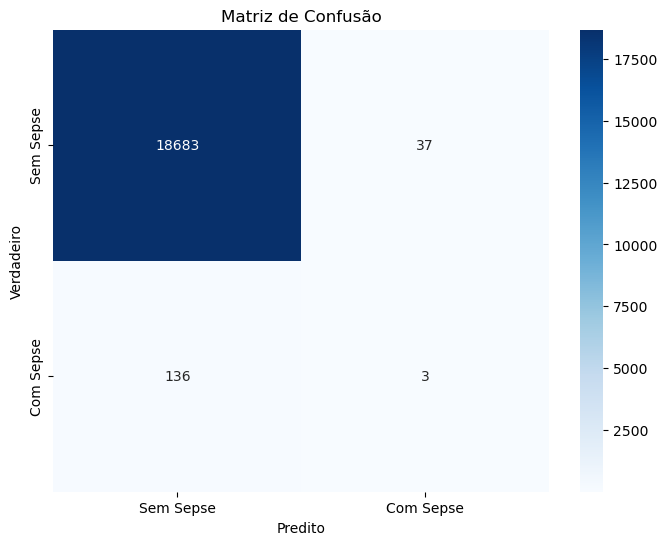

In [ ]:
XGBoost_Over(df_knn)

### Media

In [ ]:
df_media = pd.read_csv('df_media.csv')

Acurácia: 0.9925
PPV (Precision): 0.2500
Sensibilidade (Recall): 0.0072
Especificidade: 0.9998
AUC: 0.7709

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     18720
         1.0       0.25      0.01      0.01       139

    accuracy                           0.99     18859
   macro avg       0.62      0.50      0.51     18859
weighted avg       0.99      0.99      0.99     18859


Matriz de Confusão:
[[18717     3]
 [  138     1]]


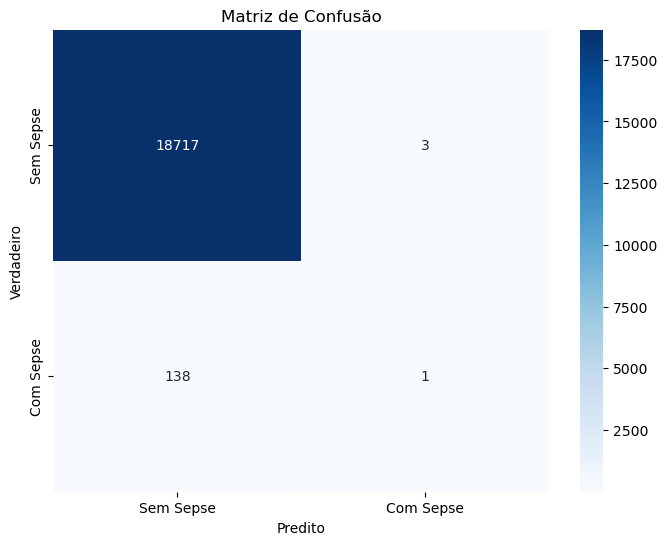

In [ ]:
XGBoost(df_media)

In [ ]:
XGBoost_Over(df_media)

KeyboardInterrupt: 

### Mediana

In [ ]:
df_mediana = pd.read_csv('df_mediana.csv')

In [ ]:
XGBoost(df_mediana)

In [ ]:
XGBoost_Over(df_mediana)

### Moda

In [ ]:
df_moda = pd.read_csv('df_moda.csv')

In [ ]:
XGBoost(df_moda)

In [ ]:
XGBoost_Over(df_moda)

### Regressão

In [ ]:
df_regressao = pd.read_csv('df_regressao.csv')

In [ ]:
XGBoost(df_regressao)

In [ ]:
XGBoost_Over(df_regressao)